# Covid-19 Research Papers Topic Modeling with K-Means and LDA

## Goal of the study

Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. **Can clustering similar research articles together simplify the search for related publications? How can the content of the clusters be qualified?**

By using clustering for labelling in combination with dimensionality reduction for visualization, the collection of literature can be represented by a scatter plot. On this plot, publications of highly similar topic will share a label and will be plotted near each other. In order, to find meaning in the clusters, topic modelling will be performed to find the keywords of each cluster.

## Approach:

- Parse the and clean text from the abstract of each document. (src/preproc.py)
- Turn each document instance $d_i$ into a feature vector $X_i$ using Term Frequency–inverse Document Frequency (TF-IDF).
- Apply Dimensionality Reduction to each feature vector $X_i$ using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two dimensional plane $X$ embedding $Y_1$.
- Use Principal Component Analysis (PCA) to project down the dimensions of $X$ to a number of dimensions that will keep .95 variance while removing noise and outliers in embedding $Y_2$.
- Apply k-means clustering on $Y_2$, where $k$ is 20, to label each cluster on $Y_1$.
- Apply Topic Modeling on $X$ using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster. 
- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD). 

<br>

In [1]:
#Import Libraries
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

# import csv
# import random
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

time: 2.7 s


# Load Data

In [2]:
df = pd.read_csv('../data/df_cleaned.csv')

time: 6.31 s


In [3]:
df.shape

(309120, 5)

time: 0 ns


In [4]:
df.head(2)

,title,abstract,publish_time,authors,url
0,Clinical features of culture-proven Mycoplasma...,objective retrospective chart describes epidem...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases respiratory tract common...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


time: 234 ms


## Word Embeddings

Using word embedding can help retain some aspects of the original context and semantics. Word2Vec generates relatively small embedding vectors in which each dimension represents an informational aspect of the word.

Due to the large size of the corpus, min_count is set to 30000 in order to retain only words with a large amount of connections. This would make the similarity visualization easier to interpret.

In [ ]:
# Word2Vec
import gensim
from gensim.models import Word2Vec

# Tokenize words in each row
df_we = df_cleaned.abstract.apply(word_tokenize)
# Implement Word2Vec
df_we = Word2Vec(df_we, size=100, window=20, min_count=30000, workers=4)

In [ ]:
# Show word similarities generated by word embeddings model
keywords = ['covid-19', 'infection', 'pandemic', 'lung', 'respiratory', 'treatment']
top_words_list = []

for i, word in enumerate(keywords):
    print(word + ":")
    top_words = df_we.most_similar(word)[:5]
    for idx, word in enumerate(top_words):
        print(str(idx+1) + ". " + word[0])
    print("")

## TSNE Model and Plot with Word Embeddings

TSNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

It takes a group of high-dimensional (100 dimensions from Word2Vec) vocabulary vectors and compresses them down to 2-dimensional xy pairs with the help of PCA.

This is another way to visualize the most essential word similarities within the large text corpus.

In [ ]:
# Create TSNE model plot based on the word embeddings
def tsne_plot(model):
    
    labels = []
    tokens = []

    for word in df_we.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, init='pca', n_iter=2500, random_state=20)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=12)
    plt.title('TSNE Plot of Similar Words', fontsize=20)
    plt.gcf().set_tight_layout(True)
    plt.show()

In [ ]:
tsne_plot(df_we)

## Vectorization

In this step, we'll convert cleaned dataframe into a format that can be handled by our algorithms. For this purpose we will be using TF-IDF. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=4096)
    X = vectorizer.fit_transform(text)
    return X

text = df['abstract'].values
X = vectorize(text, 2 ** 12)
X.shape

(309120, 4096)

time: 42.8 s


In [ ]:
# Show the 20 most frequent words
sns.set_theme(style='whitegrid')
sns.set_context('paper')
word_count = pd.DataFrame({'word': tfidf.get_feature_names(), 'count': np.asarray(X_tfidf.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh', legend=False, color='skyblue')
plt.title('Most Important Words in TFIDF Vectorizer')
ax1 = plt.axes()
ax1.axes.xaxis.set_ticklabels([])
y_axis = ax1.axes.get_yaxis()
y_axis.label.set_visible(False)
plt.show()

## PCA & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

MemoryError: Unable to allocate 9.43 GiB for an array with shape (309120, 4096) and data type float64

time: 391 ms


## K-means

In [ ]:
from sklearn.cluster import MiniBatchKMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in tqdm(K):
    k_means = MiniBatchKMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [45]:
n_clusters = 20

time: 0 ns


In [ ]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

## Dimensionality Reduction with t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

C:\Users\George\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


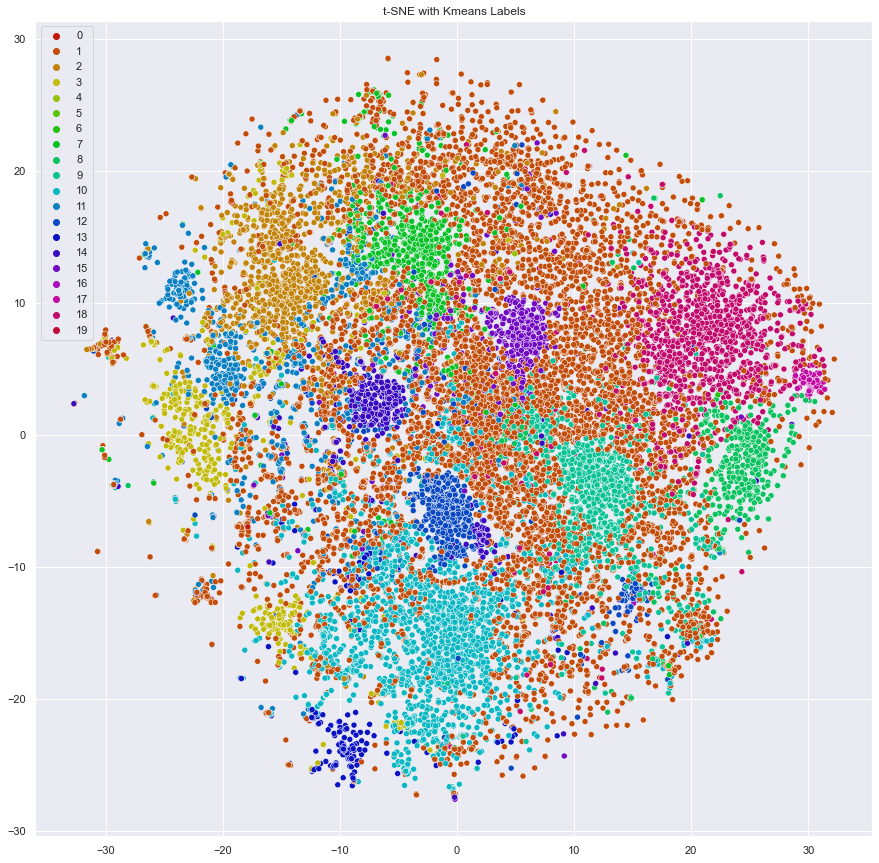

time: 2.59 s


In [40]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

## Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). The LDA model is guided by two principles:

- Each document is a mixture of topics. In a 3 topic model we could assert that a document is 70% about topic A, 30 about topic B, and 0% about topic C.

- Every topic is a mixture of words. A topic is considered a probabilistic distribution over multiple words.

<img src="../figures/LDA_usage.jpg"></img>

In particular, LDA is a imagined generative process, illustrated in the plate notation below:

<img src="../figures/LDA_GPM.png"></img>

For more LDA details, here a great article introduces LDA: https://bookdown.org/Maxine/tidy-text-mining/latent-dirichlet-allocation.html

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# create n vectors for each of our cluster detected by k-means method
vectorizers = []
    
for ii in range(0, n_clusters):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorizers[0]

In [46]:
# vectorize the data from each of our clusters
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'abstract']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 0
Not enough instances in cluster: 4
Not enough instances in cluster: 5
Not enough instances in cluster: 6
Not enough instances in cluster: 16
Not enough instances in cluster: 19
time: 1.81 s


In [47]:
len(vectorized_data)

20

time: 0 ns


Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [48]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = n_clusters

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

time: 15 ms


For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [49]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

time: 2min 1s


In [50]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

time: 0 ns


Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [51]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

time: 813 ms


In [54]:
all_keywords[0][:10]

['infection',
 'new',
 'development',
 'diseases',
 'infections',
 'respiratory',
 'protein',
 'risk',
 'research',
 'gene']

time: 15 ms


In [55]:
len(all_keywords)

14

time: 0 ns
